In [1]:
from os import path
import os

import astropy.coordinates as coord
from astropy.constants import G
from astropy.io import fits
from astropy.table import Table, QTable, join
from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import requests
import yaml

from hq.config import HQ_CACHE_PATH, config_to_alldata, config_to_jokerparams
from hq.plot import plot_two_panel, plot_phase_fold
from hq.data import get_rvdata
from hq.physics_helpers import period_at_surface, stellar_radius
from hq.mass_helpers import get_martig_mass

from thejoker.plot import plot_rv_curves
from thejoker import JokerSamples, JokerParams, TheJoker

from twobody.transforms import get_m2_min

In [2]:
plot_path = path.expanduser('~/projects/bh/plots/')
data_path = path.expanduser('~/projects/bh/data/')

In [3]:
name = 'dr16-Kprior'

In [4]:
joker_f = h5py.File('../cache/{0}/thejoker-samples.hdf5'.format(name), 'r')
emcee_f = h5py.File('../cache/{0}/emcee-samples.hdf5'.format(name), 'r')

In [5]:
with open("../cache/{}/config.yml".format(name), "r") as f:
    config = yaml.load(f.read())
    
allstar, allvisit = config_to_alldata(config)
poly_trend = config['hyperparams']['poly_trend']

In [6]:
master = QTable.read('../cache/{0}/metadata-master.fits'.format(name))
master = join(master, allstar, keys='APOGEE_ID')

In [7]:
mass_tbl = Table.read('../data/shite_m1_estimates.fits')
_, idx = np.unique(mass_tbl['APOGEE_ID'], return_index=True)
mass_tbl = mass_tbl[idx]
master = join(master, mass_tbl, keys='APOGEE_ID')

In [8]:
gaia = Table.read('../data/allStar-r12-gaiadr2.fits')
_, idx = np.unique(gaia['apogee_id'], return_index=True)
gaia = gaia[idx]
gaia.rename_column('apogee_id', 'APOGEE_ID')
master = join(master, gaia, keys='APOGEE_ID')

In [26]:
mask = (((master['STARFLAG'] & np.sum(2**np.array([2, 9]))) == 0) & # BRIGHT_NEIGHBOR, PERSIST_HIGH
        ((master['ASPCAPFLAG'] & np.sum(2**np.array([7]))) == 0)) # STAR_WARN
t = master[mask]

_, idx = np.unique(t['APOGEE_ID'], return_index=True)
t = t[idx]

len(t)

154915

In [34]:
baseline = t['periods_spanned'] * t['MAP_P'].value

In [27]:
llr = t['max_unmarginalized_ln_likelihood'] - t['robust_constant_ln_likelihood']

In [104]:
llr_mask = ((llr > 4) & 
            (np.isfinite(t['m1']) &
            (t['periods_spanned'] >= 2) & 
             (t['n_visits'] >= 3)))
llr_mask.sum()

3434

In [105]:
def m_f(P, K, e):
    """Binary mass function."""
    mf_circ = P * K**3 / (2*np.pi * G)
    return mf_circ.to(u.Msun) * (1 - e**2)**1.5

## Select the candidates

In [108]:
cool_ids = []
m2_mins = []
m1s = []
all_samples = []
# for row in tqdm(t[llr_mask]):
for row in t[llr_mask]:
    apogee_id = row['APOGEE_ID']
    m1 = row['m1'] * u.Msun
    
    if apogee_id in emcee_f.keys():
        samples = JokerSamples.from_hdf5(emcee_f[apogee_id], 
                                         poly_trend=poly_trend)
    else:
        samples = JokerSamples.from_hdf5(joker_f[apogee_id], 
                                         poly_trend=poly_trend)
    
    # data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apogee_id])
    # _ = plot_rv_curves(samples=samples, data=data)
    
    m2_min = get_m2_min(np.repeat(m1, len(samples)),
                        m_f(samples['P'], samples['K'], samples['e']))
    
    if m2_min.min() > 1.5*u.Msun and 0.5 < m1.value < 2.5:
        cool_ids.append(apogee_id)
        m2_mins.append(m2_min)
        all_samples.append(samples)
        m1s.append(m1)
        
m1s = u.Quantity(m1s)

  9%|▉         | 303/3434 [00:35<01:56, 26.85it/s]

2M02413386-0044078
2M08552622+1054187
2M15551237+2629107


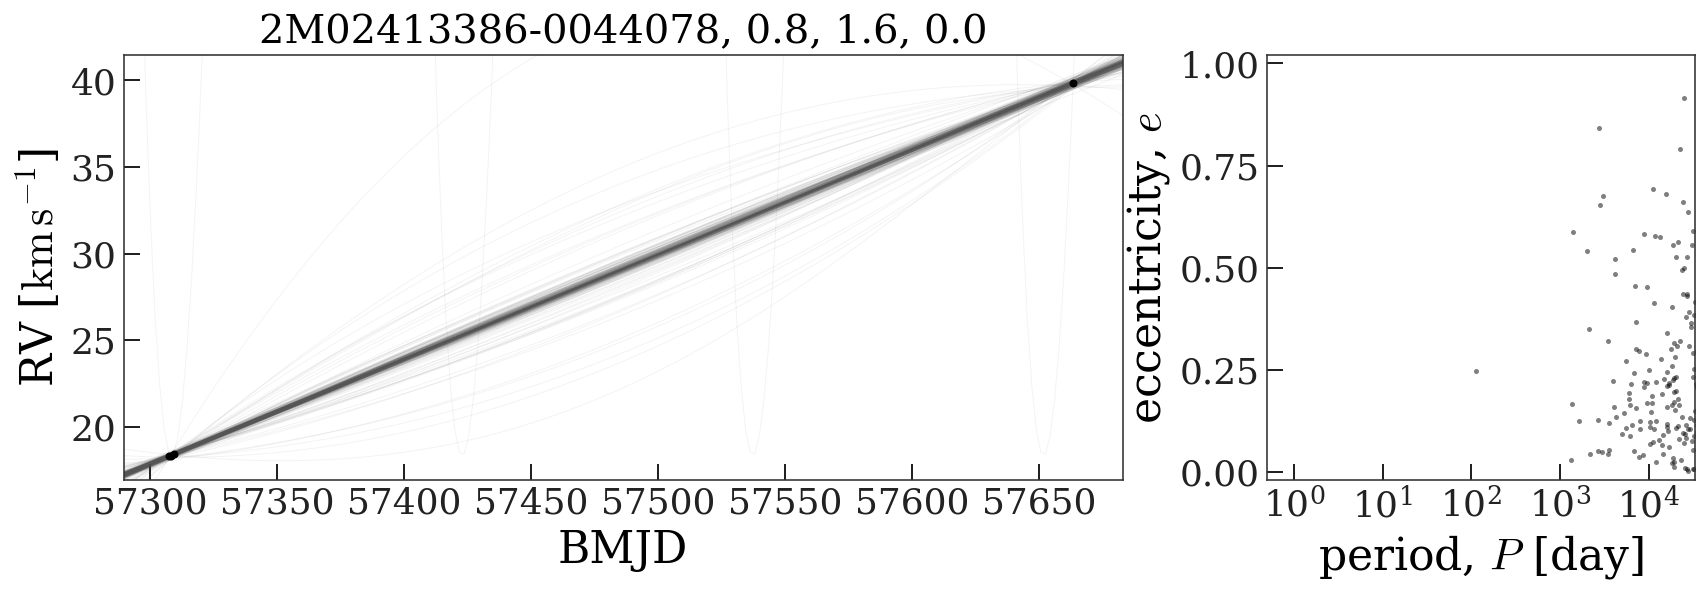

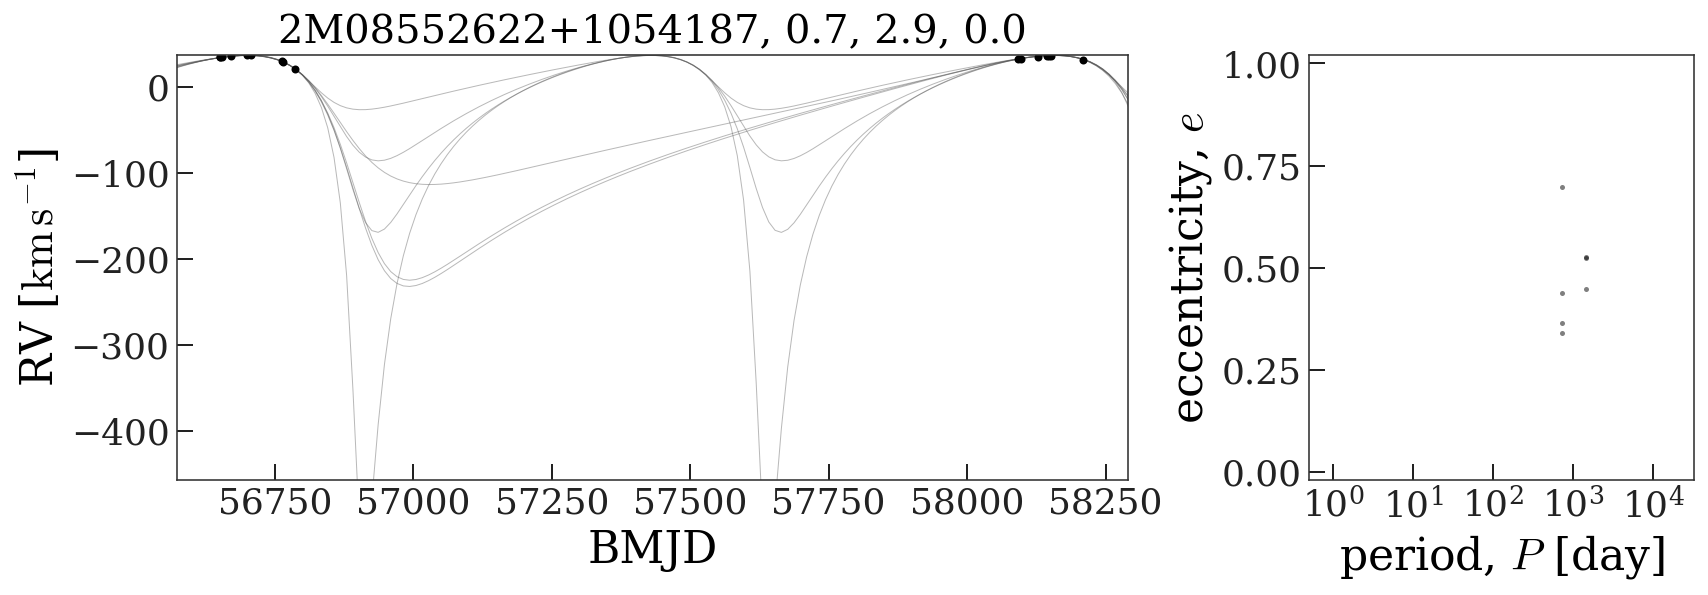

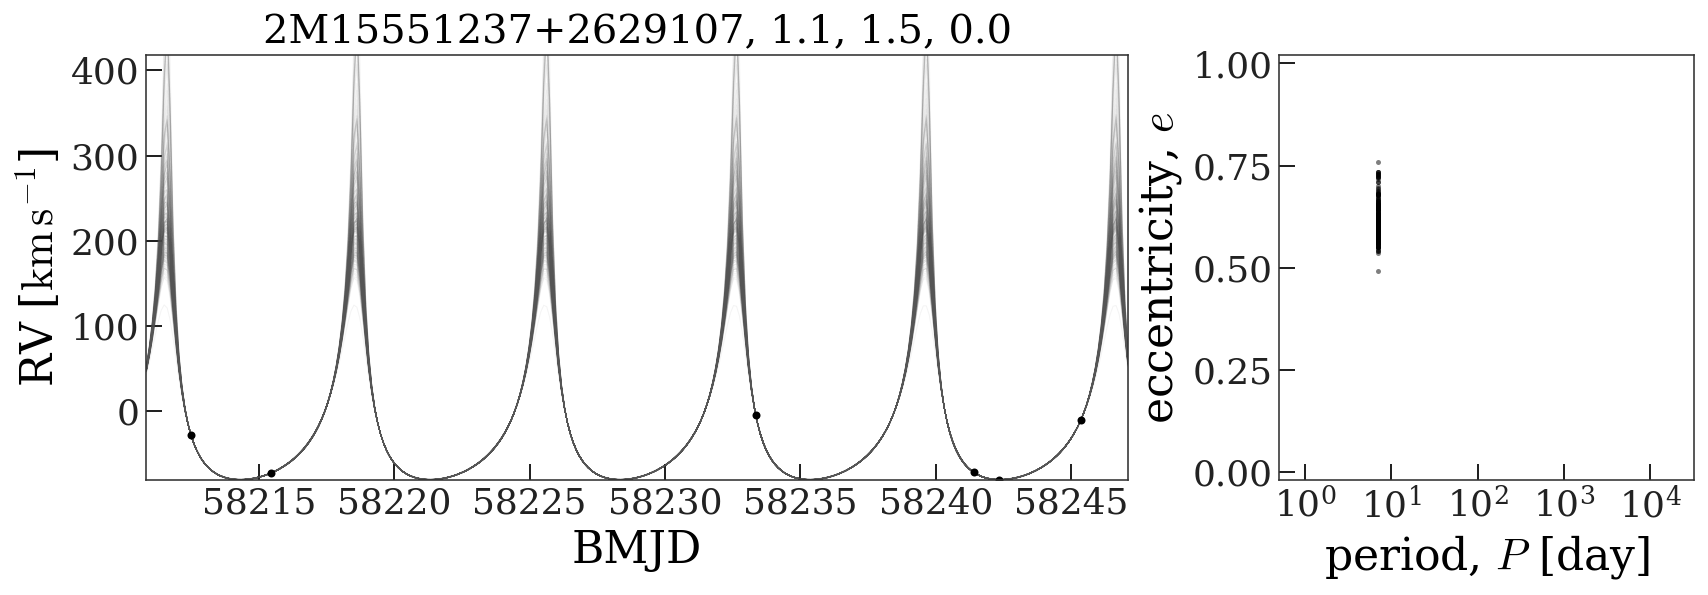

In [111]:
count = 0
for n, (apid, m1, m2_min, samples) in enumerate(zip(cool_ids, m1s, m2_mins, all_samples)):
    data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apid])
    
    print(apid)
    fig = plot_two_panel(data=data, samples=samples, 
                         title=(f'{apid}, {m1.value:.1f}, {m2_min.value.min():.1f}, {0:.1f}'
                                .format(np.percentile(m2_min, 5))))
    count += 1
    
    if count >= 16:
        break

In [89]:
candidates = master[np.isin(master['APOGEE_ID'], cool_ids)]
assert len(candidates) == len(cool_ids)
Table(candidates).write('../../bh/data/candidates.fits', overwrite=True)